In [1]:
import tensorflow as tf

# Disable all GPUS
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import pdb
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from src.models.basic_rnn import RNNMusicExperiment
from src.utils.midi_support import MidiSupport, load_midi_objs, load_just_that_one_test_song

In [4]:
# loaded_data = load_midi_objs(num_files=1, seq_length=1)
loaded_data = load_just_that_one_test_song()
note_vicinity = 24
prepared_data = MidiSupport().prepare_song_note_invariant_plus_beats_and_more(loaded_data, vicinity=note_vicinity)


/Users/trevorgordon/.venvs/sandbox_tf/lib/python3.8/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [522]:
zip(sequences, sequences2).map(helper)

AttributeError: 'zip' object has no attribute 'map'

In [526]:
seq_length = 69
X_tensor = tf.convert_to_tensor(prepared_data[0])

dataset = tf.data.Dataset.from_tensor_slices(X_tensor)
# dataset_y = tf.data.Dataset.from_tensor_slices(y_tensor)
# vocab_size = 128

# Take 1 extra for the labels
seq_length = seq_length + 1
windows = dataset.window(seq_length,
                            shift=1,
                            stride=1,
                            drop_remainder=True)

sequences = windows.flat_map(lambda x: x.batch(seq_length, drop_remainder=True))

# Split the labels
def split_labels(sequences):
    
    inputs = sequences[:-1, :, :]
    # Note 12:14 comes from architecture. first 24 elements are the vicinity. Label is in the middle
    labels = sequences[-1, :, 12:14]
    return inputs, labels

seq_ds = sequences.map(split_labels,
                        num_parallel_calls=tf.data.AUTOTUNE)



In [527]:
seq_ds.take(1)

<TakeDataset shapes: ((69, 128, 53), (128, 2)), types: (tf.int64, tf.int64)>

In [506]:
sequences.take(1), sequences2.take(1)

(<TakeDataset shapes: (69, 128, 53), types: tf.int64>,
 <TakeDataset shapes: (1, 128, 53), types: tf.int64>)

In [ ]:
# Trying to create a dataset preparer that will shift along the input sequence giving a multi to one predictor:

def prepare_windowed(self, X, y, seq_length=15):
    """
    X.shape should be ((time, num_notes, architecture)
    y.shape should be ((time, num_notes, note_or_artic) # Not the y label is already shifted by one in time and corresponds to the 'next' note


    returns:
    """

    
    # all_song_dfs = all_song_dfs.T

    print(f"all_song_dfs.shape in is {all_song_dfs.shape}")
    X_tensor = tf.convert_to_tensor(X)

    dataset = tf.data.Dataset.from_tensor_slices(X_tensor)
    vocab_size = 128

    # Take 1 extra for the labels
    windows = dataset.window(seq_length,
                                shift=1,
                                stride=1,
                                drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        x = x / vocab_size
        return x

    # Split the labels
    def split_labels(sequences, label_tensor):
        inputs = sequences[:-1]
        print(f"sequences.shape is {sequences.shape}")
        # labels_dense = sequences[-1][0]
        labels_dense = tf.reshape(sequences[-1][0:256], (256, 1))
        return inputs, {"pitch": labels_dense}

    seq_ds = sequences.map(split_labels,
                            num_parallel_calls=tf.data.AUTOTUNE)

    X_tst, y_tst = list(seq_ds.take(1))[0]
    print(f"X_tst.shape out is {X_tst.shape}")
    print(f"y_tst.shape out is {X_tst.shape}")

    return seq_ds

In [5]:
prepared_data[0].shape, prepared_data[1].shape, type(prepared_data[0])

((1206, 128, 53), (1206, 128, 2), numpy.ndarray)

In [6]:
class SwapLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(SwapLayer, self).__init__()

    def call(self, orig_tensor, training=None):
        print(f" Swaplayer input tensor shape is {orig_tensor.get_shape()}")
        swapped = tf.transpose(orig_tensor, [1, 0, 2])
        # swapped = orig_tensor
        print(f" Swaplayer output tensor shape is {swapped.get_shape()}")
        return swapped

In [7]:
class ResetModelState(tf.keras.callbacks.Callback):

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        if batch % 4 == 0:
            pass
            # # print("...Training: end of batch {}".format(batch))
            # self.model.layers[1].reset_states()
            # self.model.layers[5].reset_states()


In [146]:
def model_new(learning_rate=0.001, total_vicinity=28, dropout=0, recurrent_dropout=0):

    elements_per_time_step = 4

    # Time layers get input:
    # [Batch(notes total 128 batches), beats(whatever our total song length is), architecture dimension]
    input_shape = (elements_per_time_step, total_vicinity)

    model = tf.keras.Sequential()

    # Time layers get input:
    # Recursion along time dimension
    # " # time_inputs is a matrix (time, batch/note, input_per_note)" 
    #                         =>  (batch/note, time, input_per_note)
    #                         batch dimension is where all our extra data goes. Notes are added here
    # For a batch_amount of notes, we take an arbitrarly length time segment and train. In the batch dimensions we have the other notes for this segment and the other segments
    # [batch_amount of notes (should be 128), beats(arbitrary time sequence), architecture dimension]
    model.add(tf.keras.Input(shape=input_shape, batch_size=4))
    model.add(tf.keras.layers.LSTM(200,  return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout, stateful=True))
    # model.add(tf.keras.layers.LSTM(200,  return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout, stateful=True))
    model.add(SwapLayer())

    # Note layers get input:
    # Recursion along the note dimension
    # "# Transpose to be (note, batch/time, hidden_states)"
    #               =>  (batch/time, note, input_per_note)
    #                  batch dimension is where all our extra data goes. All changes in time within temporal sequences and across different temporal sequences go here.
    # For a single temporal sequence step, we take all notes and train. In the batch dimensions all other changes go there
    # [beats(arbitrary time sequence), Batch(notes total 128 batches), 300 node time layer output]
    # model.add(tf.keras.layers.LSTM(100,  return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout, stateful=True))
    model.add(tf.keras.layers.LSTM(100,  return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout, stateful=True))
    model.add(tf.keras.layers.Dense(2, activation="sigmoid"))

    model.summary()

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(
            loss=loss,
            optimizer=optimizer,
            # metrics=[tf.keras.metrics.BinaryCrossentropy()
            metrics=["mse"
            ]
        )
    return model, None

In [62]:
def model_new_2(learning_rate=0.001, total_vicinity=28, dropout=0, recurrent_dropout=0):

    elements_per_time_step = 128

    # Time layers get input:
    # [Batch(notes total 128 batches), beats(whatever our total song length is), architecture dimension]
    input_shape = (elements_per_time_step, total_vicinity)
    input_shape_b = (elements_per_time_step, 2)

    model = tf.keras.Sequential()

    # Time layers get input:
    # Recursion along time dimension
    # Note from Daniel Johnson Code: " # time_inputs is a matrix (time, batch/note, input_per_note)" 
    #                 Tensorflow wants batch as 0th dimension=>  (batch/note, time, input_per_note)
    #                         batch dimension is where all our extra data goes. Notes are added here
    # For a batch_amount of notes, we take an arbitrarly length time segment and train. In the batch dimensions we have the other notes for this segment and the other segments
    # [batch_amount of notes (should be 128), beats(arbitrary time sequence), architecture dimension]
    input_a = tf.keras.Input(shape=input_shape,  name="input_a")
    input_b = tf.keras.Input(shape=input_shape_b, name="input_b")

    mod_time = SwapLayer()(input_a)
    mod_time = tf.keras.layers.LSTM(200, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout, stateful=False)(mod_time)
    mod_time = SwapLayer()(mod_time)
    mod_time = tf.keras.Model(inputs=input_a, outputs=mod_time)
    # model.add(tf.keras.layers.LSTM(200,  unroll=True, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout, stateful=True))
    

    combined = tf.keras.layers.concatenate([mod_time.output, input_b])

    

    mod_notes = tf.keras.layers.LSTM(100, return_sequences=True, dropout=dropout, stateful=False)(combined)
    mod_notes = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2, activation="sigmoid"))(mod_notes)
    # mod_notes = SwapLayer()(mod_notes)
    

    model = tf.keras.Model(inputs=[input_a, input_b], outputs=[mod_notes])

    model.summary()

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(
            loss=loss,
            optimizer=optimizer,
            # metrics=[tf.keras.metrics.BinaryCrossentropy()
            metrics=["mse"
            ]
        )
    return model, None

In [ ]:
elements_per_time_step = 128

input_shape = (128, 200)

sub_model = tf.keras.Sequential()
new_input = tf.keras.Input(shape=input_shape,  name="new_input")
old_input_b = model.layers[3]

concat_lay = model.layers[4]
concat_lay.input = [new_input, old_input_b]

mod_notes = model.layers[5](concat_lay)
mod_notes = model.layers[6](mod_notes)

sub_model = tf.keras.Model(inputs=[new_input, old_input_b], outputs=[mod_notes])

sub_model.summary()

In [770]:
def model_new_2_debug(learning_rate=0.001, total_vicinity=28, dropout=0, recurrent_dropout=0):

    input_shape_b = (128, 2)
    input_b = tf.keras.Input(shape=input_shape_b, name="input_b")
    mod_notes = tf.keras.layers.LSTM(25, return_sequences=True, dropout=dropout, stateful=False)(input_b)
    mod_notes = tf.keras.layers.LSTM(25, return_sequences=True, dropout=dropout, stateful=False)(mod_notes)
    mod_notes = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2, activation="sigmoid"))(mod_notes)
    # mod_notes = tf.keras.layers.Dense(2, activation="sigmoid")(mod_notes)

    model = tf.keras.Model(inputs=[input_b], outputs=[mod_notes])

    model.summary()

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(
            loss=loss,
            optimizer=optimizer,
            # metrics=[tf.keras.metrics.BinaryCrossentropy()
            metrics=["mse"
            ]
        )
    return model, None

In [ ]:
# Need to swap time and note dimension

# Need to take 128 in the time dimension at once

In [82]:
full_len = prepared_data[0].shape[0]
even_mul_length = (full_len//128) * 128
xxx = prepared_data[0][:even_mul_length, :, :]
yyy = prepared_data[1][:even_mul_length, :, :]
yyy_other = prepared_data[1][:even_mul_length, :, :].reshape((1152*128, 2))
print(yyy_other.shape)
yyy_other = np.concatenate([np.zeros((2,2)), yyy_other[2:, :]])
yyy_other = yyy_other.reshape((1152, 128, 2))

(147456, 2)


In [10]:
print(yyy.shape)
yyy_2 = yyy.reshape((1152*4, 32, 2))
yyy_other_2 = yyy_other.reshape((1152*4, 32, 2))
print(yyy_2.shape)
print(yyy_other_2.shape)

(1152, 128, 2)
(4608, 32, 2)
(4608, 32, 2)


In [11]:
# pd.DataFrame(xxx_2[31, :, :]).T

In [12]:
print(xxx.shape)
xxx_2 = xxx.reshape((1152*4, 32, 53))
print(xxx_2.shape)


(1152, 128, 53)
(4608, 32, 53)


In [83]:



# model, callbakcs = model_new(total_vicinity=53, learning_rate=0.0001, dropout=0, recurrent_dropout=0)
# model, callbakcs = model_new_2(total_vicinity=53, learning_rate=0.0001, dropout=0, recurrent_dropout=0)

history = model.fit([xxx, yyy_other], [yyy],
    epochs=200,
    batch_size=128,
    callbacks=[ResetModelState()],
)

Epoch 1/200
9/9 [==============================] - 4s 483ms/step - loss: 0.0388 - mse: 0.0105
Epoch 2/200
9/9 [==============================] - 4s 487ms/step - loss: 0.0386 - mse: 0.0104
Epoch 3/200
9/9 [==============================] - 4s 458ms/step - loss: 0.0383 - mse: 0.0103
Epoch 4/200
9/9 [==============================] - 4s 482ms/step - loss: 0.0381 - mse: 0.0103
Epoch 5/200
9/9 [==============================] - 4s 474ms/step - loss: 0.0378 - mse: 0.0102
Epoch 6/200
9/9 [==============================] - 4s 480ms/step - loss: 0.0374 - mse: 0.0101
Epoch 7/200
9/9 [==============================] - 4s 461ms/step - loss: 0.0372 - mse: 0.0100
Epoch 8/200
9/9 [==============================] - 4s 453ms/step - loss: 0.0370 - mse: 0.0099
Epoch 9/200
9/9 [==============================] - 4s 485ms/step - loss: 0.0368 - mse: 0.0099
Epoch 10/200
9/9 [==============================] - 4s 472ms/step - loss: 0.0365 - mse: 0.0099
Epoch 11/200
9/9 [==============================] - 4s 486m

KeyboardInterrupt: 

In [416]:
xxx.shape, yyy_other.shape, yyy_pred.shape

((1152, 128, 53), (1152, 128, 2), (1152, 2))

In [84]:
# Predicting the whole thing!
yyy_pred = model.predict([xxx[:512, :, :], yyy_other[:512, :, :]], batch_size=128)

In [685]:
yyy_other_rand = np.random.uniform(size=(1152, 128, 2))
yyy_rand = np.random.uniform(size=(1152, 128, 2))
yyy_other.shape, yyy.shape, yyy_other_rand.shape, yyy_rand.shape

((1152, 128, 2), (1152, 128, 2), (1152, 128, 2), (1152, 128, 2))

In [771]:
# model, _ = model_new_2_debug()

# history = model.fit([np.random.uniform(size=(1152, 128, 2))], [np.random.uniform(size=(1152, 128, 2))],
#     epochs=1,
#     batch_size=128,
#     callbacks=[ResetModelState()],
# )

# # history = model.fit([yyy_other], [yyy],
# #     epochs=1,
# #     batch_size=128,
# #     callbacks=[ResetModelState()],
# # )

Model: "model_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_b (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 lstm_161 (LSTM)             (None, 128, 25)           2800      
                                                                 
 lstm_162 (LSTM)             (None, 128, 25)           5100      
                                                                 
 time_distributed_32 (TimeDi  (None, 128, 2)           52        
 stributed)                                                      
                                                                 
Total params: 7,952
Trainable params: 7,952
Non-trainable params: 0
_________________________________________________________________


2022-01-10 17:40:30.112093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-10 17:40:30.323738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-10 17:40:30.558776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-10 17:40:30.954848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-10 17:40:31.317661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 3s 103ms/step - loss: 0.6932 - mse: 0.0833


In [31]:
yyy_pred_128.shape, yyy.shape

((128, 128, 2), (1152, 128, 2))

In [33]:

t = pd.DataFrame(yyy[127, :, :]).T
t

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
# Predicting with part of the sequence as zero, This is reference
yyy_other_test = np.copy(yyy_other[:128, :, :])
yyy_pred_128 = model.predict([xxx[:128, :, :], yyy_other_test], batch_size=128)
t1 = pd.DataFrame(yyy_pred_128[-1, :, :]).T
t1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.003455,0.000441,0.000202,0.000136,0.000113,0.000099,0.000094,0.000090,0.000093,0.000093,0.000097,0.000099,0.000106,0.000110,0.000119,0.000124,0.000143,0.000155,0.000177,0.000199,0.000241,0.000290,0.000371,0.000456,0.000595,0.000729,0.000922,0.001099,0.001371,0.001620,0.001972,0.002222,0.002707,0.002927,0.00325,0.003342,0.003593,0.003653,0.003893,0.003923,0.004233,0.004351,0.004775,0.005037,0.005745,0.006429,0.007825,0.009268,0.012610,0.015461,0.019474,0.771081,0.012818,0.023800,0.823598,0.013893,0.025136,0.029468,0.806719,0.011963,0.020853,0.024359,0.02333,0.020775,0.021442,0.019884,0.019658,0.018230,0.018131,0.017005,0.016957,0.015818,0.015885,0.014813,0.014653,0.013551,0.013303,0.01232,0.052666,0.009616,0.012735,0.013125,0.012946,0.011379,0.010342,0.008569,0.007170,0.005312,0.003897,0.002434,0.001464,0.000814,0.000501,0.000336,0.000263,0.000216,0.000204,0.000182,0.000168,0.000148,0.000133,0.000115,0.000104,0.000093,0.000091,0.000086,0.000085,0.000082,0.000083,0.000081,0.000082,0.000081,0.000086,0.000085,0.000087,0.000086,0.000088,0.000088,0.000090,0.000090,0.000094,0.000093,0.000096,0.000095,0.000099,0.000099,0.000103,0.000104
1,0.005437,0.000594,0.000229,0.000129,0.000091,0.000074,0.000067,0.000063,0.000063,0.000065,0.000069,0.000073,0.000078,0.000083,0.000090,0.000097,0.000109,0.000119,0.000134,0.000150,0.000174,0.000203,0.000247,0.000299,0.000373,0.000456,0.000564,0.000667,0.000789,0.000896,0.001028,0.001124,0.001274,0.001366,0.00149,0.001553,0.001646,0.001687,0.001788,0.001842,0.001968,0.002087,0.002323,0.002542,0.002913,0.003319,0.004028,0.004874,0.006421,0.008129,0.010483,0.048248,0.010642,0.012628,0.058450,0.010595,0.011812,0.013388,0.051362,0.008835,0.009499,0.010522,0.01040,0.009857,0.010077,0.009749,0.009787,0.009416,0.009301,0.008806,0.008667,0.008195,0.007996,0.007569,0.007417,0.006968,0.006685,0.00616,0.322173,0.012857,0.010412,0.009373,0.008224,0.006838,0.005724,0.004457,0.003425,0.002389,0.001591,0.000949,0.000537,0.000285,0.000159,0.000098,0.000070,0.000055,0.000048,0.000043,0.000040,0.000038,0.000036,0.000034,0.000033,0.000032,0.000031,0.000030,0.000030,0.000030,0.000029,0.000029,0.000029,0.000029,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000031,0.000031,0.000032,0.000032,0.000033,0.000033,0.000034,0.000034,0.000035,0.000036


In [35]:
# Predicting with part of the sequence as zero, Does this change the sequences after
yyy_other_test = np.copy(yyy_other[:128, :, :])
yyy_other_test[:, 52:, :] = 5
yyy_pred_128 = model.predict([xxx[:128, :, :], yyy_other_test], batch_size=128)
t2 = pd.DataFrame(yyy_pred_128[-1, :, :]).T
t2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.013516,0.001920,0.000770,0.000470,0.000362,0.000304,0.000279,0.000261,0.000260,0.000256,0.000260,0.000261,0.000272,0.000278,0.000293,0.000305,0.000338,0.000363,0.000408,0.000458,0.000542,0.000634,0.000765,0.000896,0.001084,0.001260,0.001506,0.001742,0.002085,0.002411,0.002855,0.003236,0.003844,0.004266,0.004829,0.005180,0.005686,0.005927,0.006330,0.006462,0.006803,0.006884,0.007271,0.007441,0.007996,0.008410,0.009403,0.010432,0.012879,0.015649,0.020598,0.287240,0.981540,0.976948,0.976850,0.976348,0.976222,0.975877,0.975867,0.975297,0.974479,0.97219,0.968473,0.963202,0.959208,0.956486,0.955500,0.954275,0.953876,0.953130,0.953202,0.952538,0.952609,0.952060,0.95231,0.951746,0.951879,0.951508,0.951915,0.951496,0.951599,0.951208,0.951598,0.951123,0.951319,0.951007,0.951467,0.951085,0.951367,0.950986,0.951380,0.950927,0.951159,0.950881,0.951364,0.951007,0.951168,0.950827,0.951258,0.950816,0.951043,0.950763,0.951251,0.950891,0.951187,0.950822,0.951227,0.950786,0.951032,0.950769,0.951265,0.950917,0.951086,0.950755,0.951194,0.950760,0.950993,0.950722,0.951215,0.950861,0.951160,0.950798,0.951208,0.950768,0.951016,0.950754,0.951251,0.950904
1,0.015516,0.001709,0.000618,0.000358,0.000262,0.000214,0.000191,0.000178,0.000174,0.000173,0.000177,0.000180,0.000186,0.000192,0.000200,0.000208,0.000223,0.000236,0.000256,0.000277,0.000308,0.000343,0.000393,0.000444,0.000513,0.000586,0.000681,0.000772,0.000886,0.000994,0.001131,0.001246,0.001421,0.001554,0.001727,0.001845,0.001986,0.002065,0.002182,0.002229,0.002317,0.002373,0.002511,0.002607,0.002785,0.002956,0.003289,0.003669,0.004446,0.005464,0.007217,0.021917,0.860335,0.922962,0.932851,0.936260,0.937315,0.937854,0.937777,0.937677,0.936573,0.93526,0.932748,0.929680,0.926123,0.923310,0.920749,0.918694,0.916136,0.914293,0.912346,0.910989,0.909617,0.908761,0.90772,0.907274,0.906113,0.905732,0.905077,0.904950,0.904459,0.904338,0.903937,0.904053,0.903336,0.903306,0.902948,0.903066,0.902984,0.903211,0.903063,0.903376,0.902784,0.902869,0.902611,0.902822,0.902633,0.902773,0.902600,0.902902,0.902326,0.902408,0.902158,0.902360,0.902367,0.902662,0.902586,0.902955,0.902401,0.902516,0.902288,0.902530,0.902373,0.902539,0.902389,0.902713,0.902155,0.902248,0.902010,0.902224,0.902242,0.902549,0.902475,0.902854,0.902305,0.902428,0.902206,0.902454


In [36]:
t1 - t2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.942166,-0.924320,-0.503686,-0.914381,-0.903161,-0.907305,-0.466340,-0.911909,-0.90426,-0.908847,-0.907846,-0.907426,-0.903568,-0.90466,-0.904835,-0.906935,-0.907176,-0.909284,-0.910064,-0.911900,-0.912475,-0.914351,-0.915120,-0.916727,-0.917313,-0.919093,-0.874049,-0.915646,-0.915291,-0.918842,-0.920998,-0.923962,-0.926514,-0.930080,-0.933799,-0.937600,-0.941405,-0.944488,-0.947195,-0.948339,-0.949467,-0.949753,-0.950542,-0.950378,-0.950625,-0.950354,-0.950819,-0.950406,-0.950645,-0.950378,-0.950865,-0.950505,-0.950787,-0.950418,-0.950811,-0.950364,-0.950595,-0.950326,-0.950811,-0.950460,-0.950607,-0.950274,-0.950703,-0.950267,-0.950489,-0.950215,-0.950699,-0.950345,-0.950629,-0.950268,-0.950668,-0.950227,-0.950460,-0.950194,-0.950677,-0.950326
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.846774,-0.906295,-0.887555,-0.914317,-0.914335,-0.914022,-0.882885,-0.914148,-0.91409,-0.913497,-0.911285,-0.909111,-0.905453,-0.90337,-0.900949,-0.899674,-0.897516,-0.896617,-0.895062,-0.894573,-0.893651,-0.893513,-0.892695,-0.892914,-0.892189,-0.892650,-0.796739,-0.876548,-0.883601,-0.887398,-0.889228,-0.891595,-0.892707,-0.894714,-0.896109,-0.898063,-0.899507,-0.901001,-0.901698,-0.902557,-0.902267,-0.902527,-0.902363,-0.902631,-0.902473,-0.902632,-0.902469,-0.902777,-0.902203,-0.902287,-0.902035,-0.902237,-0.902241,-0.902534,-0.902452,-0.902818,-0.902261,-0.902375,-0.902142,-0.902383,-0.902220,-0.902385,-0.902231,-0.902554,-0.901993,-0.902087,-0.901845,-0.902059,-0.902075,-0.902380,-0.902301,-0.902679,-0.902127,-0.902249,-0.902022,-0.902269


In [555]:
xxx.shape, yyy.shape, yyy_pred.shape

((1152, 128, 53), (1152, 128, 2), (1152, 128, 2))

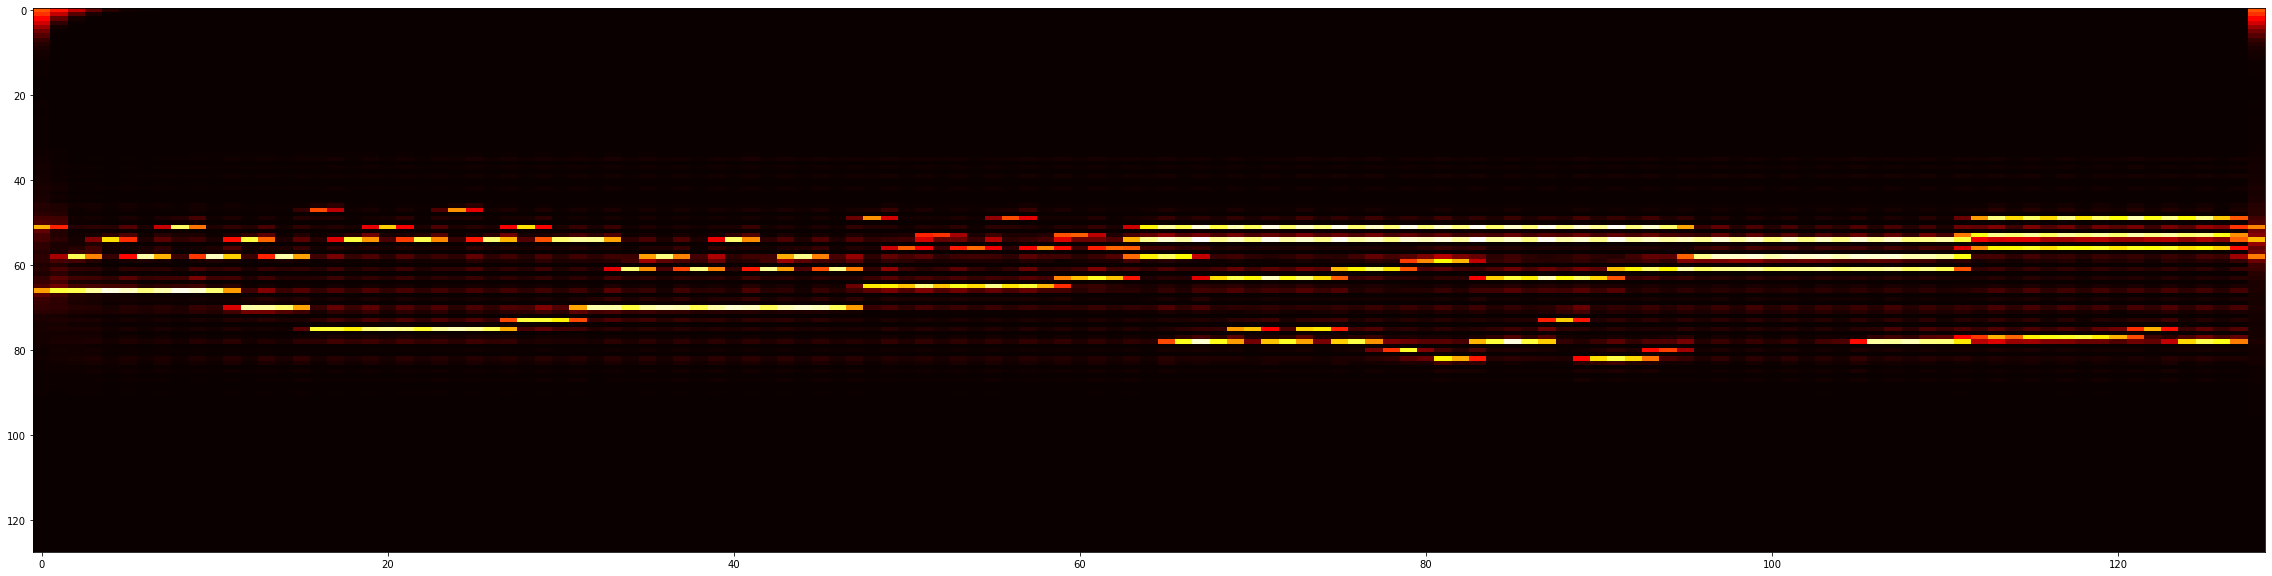

In [87]:
import matplotlib.pyplot as plt

# data = yyy_pred.reshape((1152, 128, 2))
data = yyy_pred
data = data[:129,  :, 0]
plt.rcParams["figure.figsize"] = (40,10)
plt.imshow(data.T, cmap='hot', interpolation='nearest', aspect="auto")

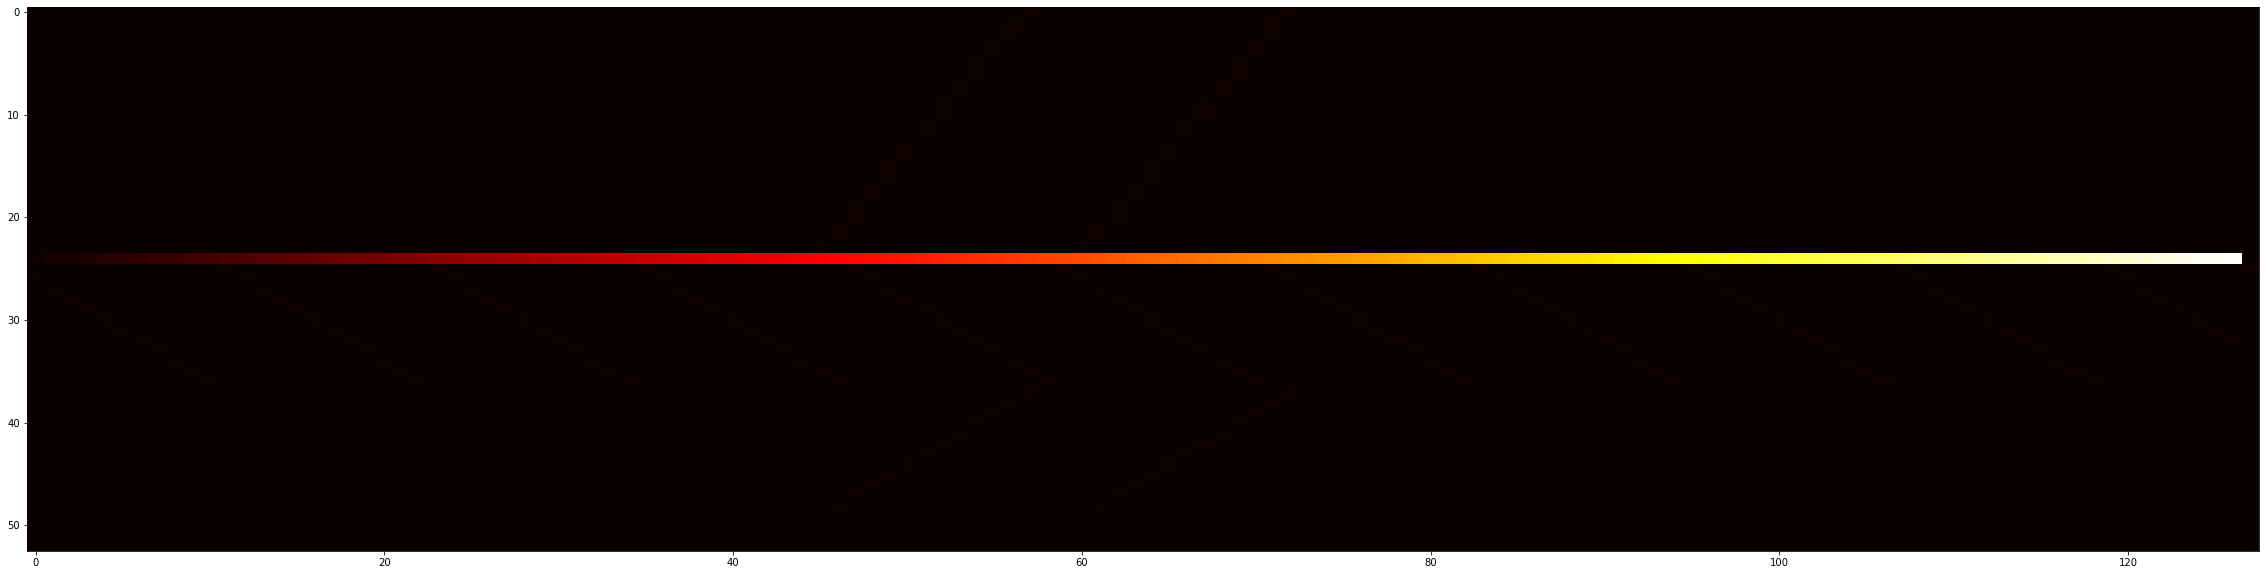

In [61]:
import matplotlib.pyplot as plt

# data = yyy_pred.reshape((1152, 128, 2))
data = input_notes[0, :, :]
plt.rcParams["figure.figsize"] = (40,10)
plt.imshow(data.T, cmap='hot', interpolation='nearest', aspect="auto")

In [188]:
def predict_time_note_model(size=16):
    reshaped_train_data = xxx
    reshaped_train_data_labels = yyy
    reshaped_train_data_labels_for_input = yyy_other
    num_beats=128
    # size=16

    batch_sequence_size = 32

    note_vicinity=24
    outputs = []
    all_probs = []
    num_notes = 128
    total_vicinity = 53
    # offset = np.random.choice(range(len(reshaped_train_data)))
    offset = 0
    input_notes = reshaped_train_data[offset:offset+num_beats, :, :]
    input_notes_b = reshaped_train_data_labels_for_input[offset:offset+num_beats, :, :]
    input_notes_b = input_notes_b.reshape((num_beats*num_notes, 2))
    input_notes_b = np.concatenate([np.zeros((1,2)), input_notes_b[1:, :]])
    input_notes_b = input_notes_b.reshape((num_beats, num_notes, 2))

    last_beats =[str(x) for x in input_notes[0, -1, -4:]]
    last_beats_int = int("".join(last_beats), 2)

    # input_notes_b_reshape = input_notes_b.reshape((num_beats*(128//batch_sequence_size), batch_sequence_size, 2))
    # input_notes_reshape = input_notes.reshape((num_beats*(128//batch_sequence_size), batch_sequence_size, 53))
    input_notes_reshape = input_notes
    input_notes_b_reshape = input_notes_b

    input_notes_b_reshape = np.concatenate([input_notes_b_reshape[1:, :, :], np.zeros((1, num_beats, 2))], axis=0)

    for l in range(size):
        print(l)
        

        out_arr = np.zeros((num_notes,2))
        probs_arr = np.zeros((num_notes,2))

        # model.layers[5].reset_states()

        reset = True
        model.reset_states()
    
        for i in range(num_notes):
            #TODO: Speed this up by not repredicting the time axis layers.

            if i == 0:
                probs = model.predict([input_notes_reshape, input_notes_b_reshape], batch_size=128)
                
                # Sub Model

                intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                                outputs=model.layers[3].output)
                intermediate_output = intermediate_layer_model.predict([input_notes_reshape, input_notes_b_reshape], batch_size=128)

                input_shape = (128, 200)

                sub_model = tf.keras.Sequential()
                new_input = tf.keras.Input(shape=input_shape,  name="new_input")
                old_input_b = model.layers[4]


                concat_lay = model.layers[5]([new_input, old_input_b.output])
                

                mod_notes = model.layers[6](concat_lay)
                mod_notes = model.layers[7](mod_notes)

                sub_model = tf.keras.Model(inputs=[new_input, old_input_b.input], outputs=[mod_notes])

 

            else:
                probs = sub_model.predict([intermediate_output, input_notes_b_reshape], batch_size=128)
        
            last_new_play_artic_probs = probs[-1, i, :]
            last_new_play_artic = np.random.binomial(1, last_new_play_artic_probs, size=None).reshape((1, 2))


            if i < (num_notes - 1):
                input_notes_b_reshape[-1, i:i+1, :] = last_new_play_artic
            else:
                print("Is this getting hit")
                input_notes_b_reshape = np.concatenate([input_notes_b_reshape[1:, :, :], np.zeros((1, num_beats, 2))], axis=0)

            probs_arr[i, 0] = last_new_play_artic_probs[0]
            probs_arr[i, 1] = last_new_play_artic_probs[1]
            out_arr[i, 0] = last_new_play_artic[0, 0]
            out_arr[i, 1] = last_new_play_artic[0, 1]

        out = out_arr.reshape((256,1))
        probs = probs_arr.reshape((256,1))


        # Need to window across out to get the input form again.
        out = out.reshape((256,1))
        probs = probs.reshape((256,))
        outputs.append(out.reshape(256,))
        all_probs.append(probs)

        # note_vicinity = total_vicinity-4-12-12-1
        next_pred, _, _ = MidiSupport().windowed_data_across_notes_time(out, mask_length_x=note_vicinity, return_labels=False)# Return (total_vicinity, 128)

        # Get array of Midi values for each note value
        n_notes = 128
        midi_row = MidiSupport().add_midi_value(next_pred, n_notes)

        # Get array of one hot encoded pitch values for each note value
        pitchclass_rows = MidiSupport().calculate_pitchclass(midi_row, next_pred)

        # Add total_pitch count repeated for each note window
        previous_context = MidiSupport().build_context(next_pred, midi_row, pitchclass_rows)

        midi_row = midi_row.reshape((1, -1))
        next_pred = np.vstack((next_pred, midi_row, pitchclass_rows, previous_context))
        
        last_beats_int += 1
        last_beats_int = last_beats_int%16
        next_beats_ind = np.array([int(x) for x in bin(last_beats_int)[2:].zfill(4)])
        next_beats_ind = next_beats_ind.reshape((4, 1))
        next_beats_ind = np.repeat(next_beats_ind, num_notes, axis=1)

        # TODO, check if beat is correctly increasing: might need to flip it before adding
        last_new_note = np.concatenate([next_pred, next_beats_ind])
        last_new_note = last_new_note[np.newaxis, :, :] # Shape now  (1, 28, 128)
        last_new_note = np.swapaxes(last_new_note, 1, 2) # Shape now  (1, 128, 28)
        # last_new_note = np.swapaxes(last_new_note, 0, 1) # Shape now  (128, 1, 28)
        
        together = np.concatenate([input_notes_reshape[1:, :, :], last_new_note], axis=0)
        input_notes_reshape = together

    outputs_joined = pd.DataFrame(outputs)
    all_probs_joined = pd.DataFrame(all_probs)
    return outputs_joined, all_probs_joined


In [185]:
# model.layers[3].output, model.layers[4].input
model.input

[<KerasTensor: shape=(None, 128, 53) dtype=float32 (created by layer 'input_a')>,
 <KerasTensor: shape=(None, 128, 2) dtype=float32 (created by layer 'input_b')>]

In [190]:
# %prun 
outputs_joined, all_probs_joined = predict_time_note_model(size=100)

0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 128, 2), dtype=tf.float32, name='input_b'), name='input_b', description="created by layer 'input_b'")
 Swaplayer input tensor shape is (128, 128, 53)
 Swaplayer output tensor shape is (128, 128, 53)
 Swaplayer input tensor shape is (128, 128, 200)
 Swaplayer output tensor shape is (128, 128, 200)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 128, 2), dtype=tf.float32, name='input_b'), name='input_b', description="created by layer 'input_b'")
Is this getting hit
1
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 128, 2), dtype=tf.float32, name='input_b'), name='input_b', description="created by lay

In [121]:
np.array([[1, 2], [3,4], [5,6]]).reshape((6, 1))

array([[1],
       [2],
       [3],
       [4],
       [5],
       [6]])

In [113]:
out.T.shape, input_notes_reshape[-1, :, 12:14].reshape((1, 256)).shape

((1, 256), (1, 256))

In [114]:
pd.DataFrame(out.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
pd.DataFrame(input_notes_reshape[-1, :, 12:14].reshape((1, 256)))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [142]:
input_notes_reshape.shape, input_notes_b_reshape.shape, input_notes_reshape[:, -1:, :].shape, input_notes_b_reshape[:, -1:, :].shape

((256, 32, 53), (256, 32, 2), (256, 1, 53), (256, 1, 2))

In [137]:
model.layers[0].output, model.layers[2].output

(<KerasTensor: shape=(32, 32, 53) dtype=float32 (created by layer 'input_a')>,
 <KerasTensor: shape=(32, 32, 200) dtype=float32 (created by layer 'swap_layer_10')>)

In [141]:
# probs = model.predict([input_notes_reshape[:, -1:, :], input_notes_b_reshape[:, -1:, :]], batch_size=1)
probs = model.predict([input_notes_reshape, input_notes_b_reshape], batch_size=32)
probs.shape
# input_notes_reshape.shape, input_notes_b_reshape.shape

(256, 32, 2)

In [76]:
input_notes_reshape.shape, input_notes_b_reshape.shape

((60, 32, 53), (60, 32, 2))

In [77]:
xxx_2.shape, yyy_other_2.shape

((4608, 32, 53), (4608, 32, 2))

In [80]:
batch_sequence_size

32

In [100]:
outputs_joined.shape

(10, 256)

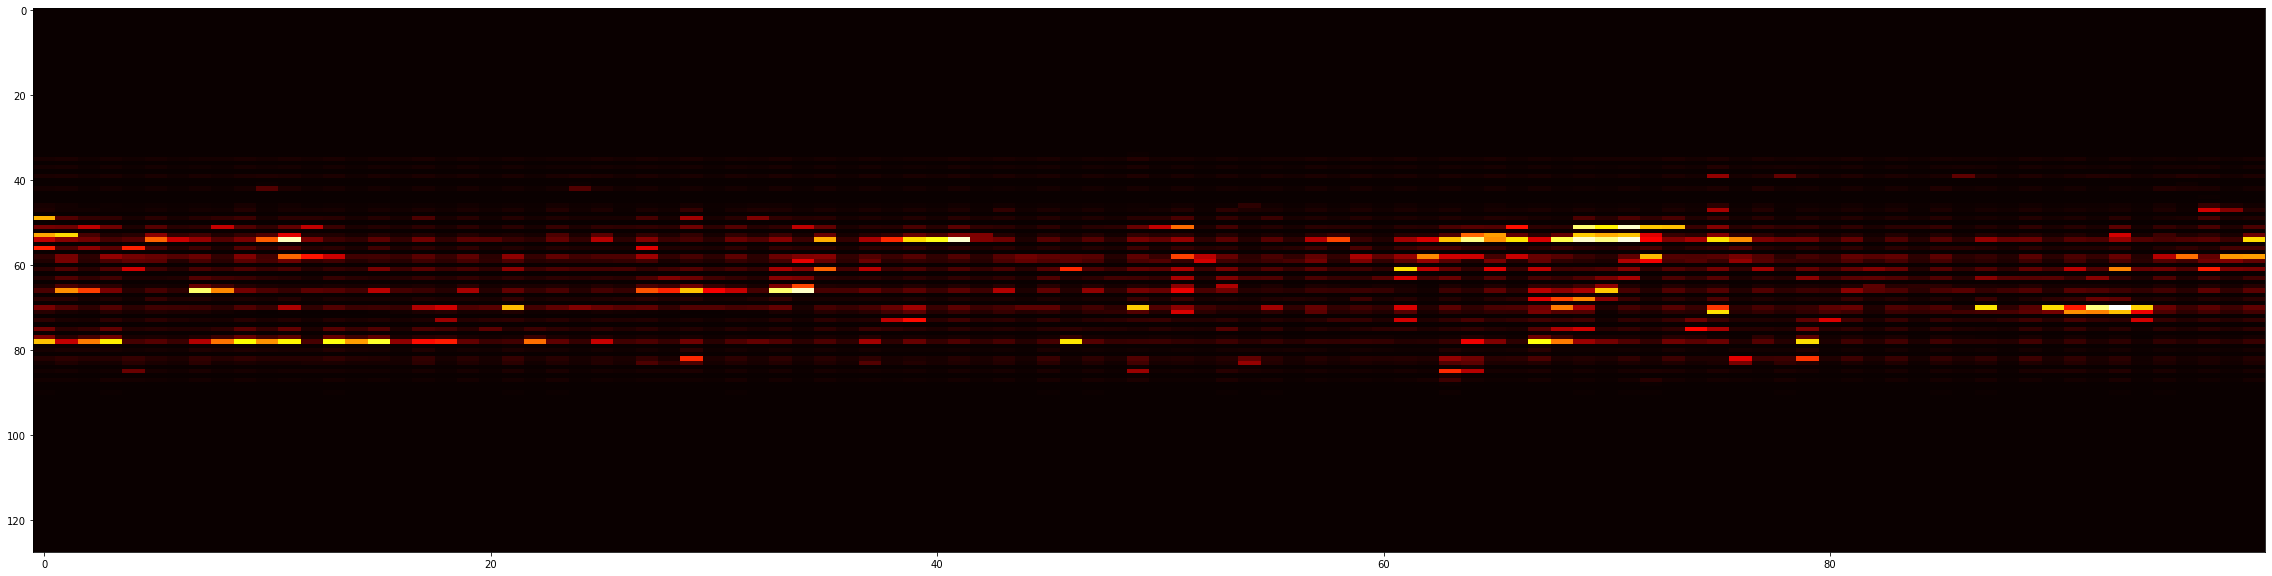

In [197]:
import matplotlib.pyplot as plt
from src.utils.visualization import note_and_artic_to_one

# data = yyy_pred.reshape((1152, 128, 2))
# data = all_probs_joined[:,  :, 0]

# outputs_joined, all_probs_joined 

data = note_and_artic_to_one(all_probs_joined, what="note_hold")
plt.rcParams["figure.figsize"] = (40,10)
plt.imshow(data, cmap='hot', interpolation='nearest', aspect="auto")

In [124]:
all_probs_joined

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.001376,0.001503,0.001460,0.001371,0.001459,0.001370,0.001458,0.001370,0.001458,0.001370,...,0.001458,0.001370,0.001458,0.001370,0.001458,0.001370,0.001458,0.001370,0.001458,0.001370
1,0.001081,0.001585,0.001084,0.001588,0.001084,0.001588,0.001084,0.001588,0.001085,0.001587,...,0.001085,0.001587,0.001085,0.001587,0.001085,0.001587,0.001085,0.001587,0.001085,0.001587
2,0.000845,0.001726,0.000843,0.001732,0.000843,0.001732,0.000843,0.001732,0.000843,0.001732,...,0.000843,0.001732,0.000843,0.001732,0.000843,0.001732,0.000843,0.001732,0.000843,0.001732
3,0.000699,0.001779,0.000698,0.001783,0.000698,0.001783,0.000698,0.001783,0.000698,0.001783,...,0.000698,0.001783,0.000698,0.001783,0.000698,0.001783,0.000698,0.001783,0.000698,0.001783
4,0.000632,0.001842,0.000632,0.001845,0.000632,0.001845,0.000632,0.001845,0.000632,0.001845,...,0.000632,0.001845,0.000632,0.001845,0.000632,0.001845,0.000632,0.001845,0.000632,0.001845
5,0.000634,0.001741,0.000633,0.001742,0.000633,0.001741,0.000633,0.001741,0.000633,0.001741,...,0.000633,0.001740,0.000633,0.001740,0.000633,0.001740,0.000633,0.001740,0.000633,0.001740
6,0.000648,0.001672,0.000646,0.001672,0.000645,0.001671,0.000645,0.001671,0.000645,0.001671,...,0.000645,0.001671,0.000645,0.001671,0.000645,0.001671,0.000645,0.001671,0.000645,0.001671
7,0.000648,0.001656,0.000645,0.001657,0.000644,0.001657,0.000644,0.001657,0.000644,0.001658,...,0.000644,0.001658,0.000644,0.001658,0.000644,0.001658,0.000644,0.001658,0.000644,0.001658
8,0.000658,0.001733,0.000655,0.001742,0.000655,0.001743,0.000655,0.001743,0.000655,0.001743,...,0.000655,0.001743,0.000655,0.001743,0.000655,0.001743,0.000655,0.001743,0.000655,0.001743
9,0.000695,0.001729,0.000697,0.001741,0.000698,0.001744,0.000698,0.001745,0.000698,0.001745,...,0.000698,0.001745,0.000698,0.001745,0.000698,0.001745,0.000698,0.001745,0.000698,0.001745


In [733]:

input_shape = (10, 5)

model_tst = tf.keras.Sequential()

model_tst.add(tf.keras.Input(shape=input_shape))
model_tst.add(tf.keras.layers.LSTM(100,  return_sequences=True))
model_tst.add(tf.keras.layers.Dense(2, activation="sigmoid"))

model_tst.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model_tst.compile(
        loss=loss,
        optimizer=optimizer,
        # metrics=[tf.keras.metrics.BinaryCrossentropy()
        metrics=["mse"
        ]
    )

model_tst.summary()


Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_139 (LSTM)             (None, 10, 100)           42400     
                                                                 
 dense_65 (Dense)            (None, 10, 2)             202       
                                                                 
Total params: 42,602
Trainable params: 42,602
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_139 (LSTM)             (None, 10, 100)           42400     
                                                                 
 dense_65 (Dense)            (None, 10, 2)             202       
                                                                 
Total params: 42,602
Train

In [745]:
b_size = 5
random_input = np.ones((11, 1000, 5))
random_output = model_tst.predict(random_input, batch_size=100)[0, :, :].reshape(1000, 2)
random_input[:, 8:, :] = 99
random_output2 = model_tst.predict(random_input, batch_size=100)[0, :, :].reshape(1000, 2)
random_output3 = model_tst.predict(random_input, batch_size=100)[0, :, :].reshape(1000, 2)
diff = random_output - random_output2
pd.DataFrame(diff).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.004554,-0.030177,-0.072558,-0.182296,-0.198521,-0.201616,-0.203007,-0.204214,-0.20541

In [738]:
diff2 = random_output3 - random_output2
pd.DataFrame(diff2).T

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,-0.004554,0.030177,0.061376,0.016552,0.068042
1,0.0,0.0,0.0,0.0,0.0,0.055126,0.037456,-0.051067,-0.124175,-0.058899


In [581]:
history = model_tst.fit(np.random.uniform(size=(1152, 128, 53)), np.random.uniform(size=(1152, 128, 2)),
    epochs=2,
    batch_size=1,
)

Epoch 1/2
100/100 [==============================] - 2s 16ms/step - loss: 0.7036 - mse: 0.0865
Epoch 2/2
100/100 [==============================] - 2s 16ms/step - loss: 0.6948 - mse: 0.0823


In [583]:
random_input = np.ones((1, 10, 5))
random_output = model_tst.predict(random_input).reshape(10, 2)
random_input[:, 4:, :] = 99
random_output2 = model_tst.predict(random_input).reshape(10, 2)
diff = random_output - random_output2
pd.DataFrame(diff).T

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,-0.001110,-0.008770,-0.003744,-0.013602,-0.00649,-0.016743
1,0.0,0.0,0.0,0.0,-0.020292,-0.014005,-0.016000,-0.018745,-0.01912,-0.021157


In [578]:
np.random.uniform(size=(1, 10, 2)).shape

(1, 10, 2)

In [767]:

input_shape = (10, 5)

model_tst = tf.keras.Sequential()

model_tst.add(tf.keras.Input(shape=input_shape))
model_tst.add(tf.keras.layers.LSTM(2,  return_sequences=True))
model_tst.add(tf.keras.layers.Dense(2, activation="sigmoid"))

model_tst.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model_tst.compile(
        loss=loss,
        optimizer=optimizer,
        # metrics=[tf.keras.metrics.BinaryCrossentropy()
        metrics=["mse"
        ]
    )


random_input = np.ones((11, 10, 5))
# random_input = np.random.uniform(size=(11, 10, 5))
random_input[:, 8:, :] = 99
random_output2 = model_tst.predict(random_input, batch_size=1)[0, :, :].reshape(10, 2)
random_output3 = model_tst.predict(random_input, batch_size=10)[0, :, :].reshape(10, 2)
diff2 = random_output3 - random_output2
pd.DataFrame(diff2).T


Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_158 (LSTM)             (None, 10, 2)             64        
                                                                 
 dense_73 (Dense)            (None, 10, 2)             6         
                                                                 
Total params: 70
Trainable params: 70
Non-trainable params: 0
_________________________________________________________________


2022-01-10 17:32:37.604123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-10 17:32:37.644558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-10 17:32:37.858138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-10 17:32:37.910389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [764]:
pd.DataFrame(out_batch_1).T

,0,1,2,3,4,5,6,7,8,9
0,0.038585,0.075018,0.099508,0.113639,0.120910,0.124124,0.125129,0.125047,-0.006011,-0.134312
1,0.025758,0.054718,0.080744,0.102315,0.119503,0.132902,0.143210,0.151065,0.243405,0.303306


In [765]:
pd.DataFrame(out_batch_10).T

,0,1,2,3,4,5,6,7,8,9
0,0.038585,0.075018,0.099508,0.113639,0.120910,0.112897,0.087879,0.096757,0.114014,0.181670
1,0.025758,0.054718,0.080744,0.102315,0.119503,0.128028,0.149749,0.158353,0.196497,0.214949


In [786]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tensorflow as tf
import numpy as np
import pandas as pd

# Setup model
input_shape = (10, 5)

model_tst = tf.keras.Sequential()

model_tst.add(tf.keras.Input(shape=input_shape))
model_tst.add(tf.keras.layers.LSTM(100,  return_sequences=True))
model_tst.add(tf.keras.layers.Dense(2, activation="sigmoid"))

model_tst.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model_tst.compile(
        loss=loss,
        optimizer=optimizer,
        # metrics=[tf.keras.metrics.BinaryCrossentropy()
        metrics=["mse"
        ]
)

# Generate step data
random_input = np.ones((11, 10, 5))
random_input[:, 8:, :] = 2

# Predictions
random_output2 = model_tst.predict(random_input, batch_size=1)[0, :, :].reshape(10, 2)
random_output3 = model_tst.predict(random_input, batch_size=10)[0, :, :].reshape(10, 2)

# Compare results
diff2 = random_output3 - random_output2
pd.DataFrame(diff2).T

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_174 (LSTM)             (None, 10, 2)             64        
                                                                 
 dense_86 (Dense)            (None, 10, 2)             6         
                                                                 
Total params: 70
Trainable params: 70
Non-trainable params: 0
_________________________________________________________________


2022-01-10 19:02:02.662990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-10 19:02:02.698816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-10 19:02:02.908405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-10 19:02:02.950191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [780]:
os.environ["CUDA_VISIBLE_DEVICES"]

'1'

In [787]:

# Disable all GPUS
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'

RuntimeError: Visible devices cannot be modified after being initialized